#### Lab04 
## Forecasting Several Time Steps Ahead
- RNN으로 여러개를 예측하기 (loop_forward)

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import myplot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model


In [2]:
def generate_time_series(batch_size, n_steps):        
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    
    time = np.linspace(0, 1, n_steps)    
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2    
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise    
    return series[..., np.newaxis].astype(np.float32)

In [3]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [4]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(1000, n_steps + 10)
X_train = series[:700, :n_steps]
X_valid = series[700:900, :n_steps]
X_test = series[900:, :n_steps]
Y = np.empty((1000, n_steps, 10))

for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:700]
Y_valid = Y[700:900]
Y_test = Y[900:]

## Using One-Dimensional Convolutional Layers to Process Sequences

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

cnn1d = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model = cnn1d

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          100       
_________________________________________________________________
gru (GRU)                    (None, None, 20)          2520      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________


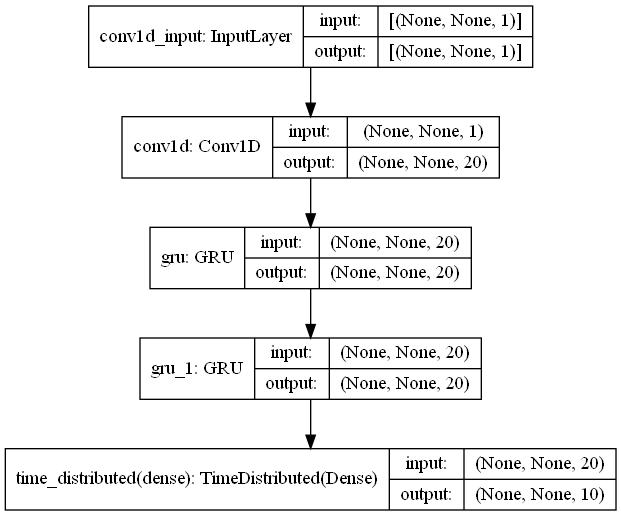

In [6]:
model.summary()
plot_model(model, to_file='./b6_model_GRU_TimeD.png', show_shapes=True)

In [7]:
%%time
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
22/22 [==============================] - 8s 136ms/step - loss: 0.1280 - last_time_step_mse: 0.1237 - val_loss: 0.1137 - val_last_time_step_mse: 0.1191
Epoch 2/20
22/22 [==============================] - 2s 83ms/step - loss: 0.0979 - last_time_step_mse: 0.0908 - val_loss: 0.0819 - val_last_time_step_mse: 0.0791
Epoch 3/20
22/22 [==============================] - 2s 83ms/step - loss: 0.0728 - last_time_step_mse: 0.0630 - val_loss: 0.0654 - val_last_time_step_mse: 0.0588
Epoch 4/20
22/22 [==============================] - 2s 84ms/step - loss: 0.0633 - last_time_step_mse: 0.0524 - val_loss: 0.0605 - val_last_time_step_mse: 0.0529
Epoch 5/20
22/22 [==============================] - 2s 86ms/step - loss: 0.0598 - last_time_step_mse: 0.0488 - val_loss: 0.0579 - val_last_time_step_mse: 0.0498
Epoch 6/20
22/22 [==============================] - 2s 83ms/step - loss: 0.0574 - last_time_step_mse: 0.0467 - val_loss: 0.0556 - val_last_time_step_mse: 0.0482
Epoch 7/20
22/22 [===============

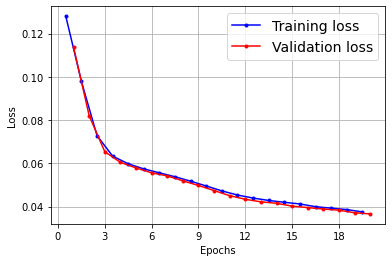

In [8]:
myplot.plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [9]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

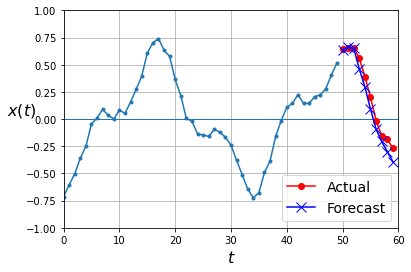

In [10]:
myplot.plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [11]:
b7 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of 1D CNN :', b7)

The loss of 1D CNN : 0.03752586618065834


# Results Summary

In [14]:
models = pd.DataFrame({
    'Model': ['1D_CNN_RNN+loopforward'],
    'Score': [b7 ]})
models.sort_values(by='Score', ascending=True)

Model     Score
0  1D_CNN_RNN+loopforward  0.037526